In [76]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import src.DFS_common_neighbor as dcn
import seaborn as sns

r_seed = 12345

### Generate a random graph for test

nodes 0 - 99 will be in a community, and nodes 100 - 199 will be in another community

In [2]:
N = 200
n_groups = 2
p_in_group = 0.3
p_out_group = 0.01

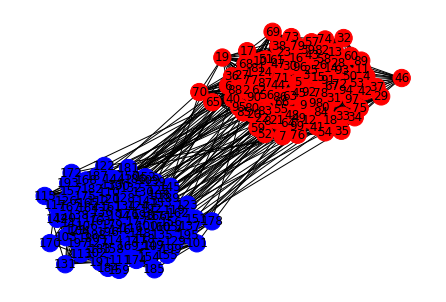

In [3]:
G = nx.planted_partition_graph(n_groups, 100, p_in_group, p_out_group, seed=r_seed)
G_pos = nx.spring_layout(G, seed = r_seed)
nx.draw(G, G_pos, with_labels=True, node_color=["r"] * 100 + ["b"] * 100)

### Use number of common neighbors

Networkx gives common neighbors like following

In [4]:
list(nx.common_neighbors(G, 0, 1))

[22, 39, 44, 54, 58, 73, 79, 87, 94]

Natively, we assume higher number of common neighbors means they are in a same community. Thus, we first compute the number of common neighbor of all pairs, and the average number of common neighbors. If two nodes pairs has number of common neighbors greater than the average number of common neighbors, we make them in a community.

In [5]:
# calculate number of common neighbors
common_neighbors_dict = {}
for i in G.nodes:
    for j in G.nodes:
        if i == j :
            continue

        num_common_neighbors = len(list(nx.common_neighbors(G, i, j)))
        common_neighbors_dict[(i, j)] = num_common_neighbors

We choose 1 as the threshold of common neighbors as the threshold for partitioning.

In [6]:
community = set()
for key in common_neighbors_dict:
    num_common_neighbors = common_neighbors_dict[key]
    if num_common_neighbors > 1:
        i, j = key

        community.add(i)
        community.add(j)

pred_clique_idx = list(community)

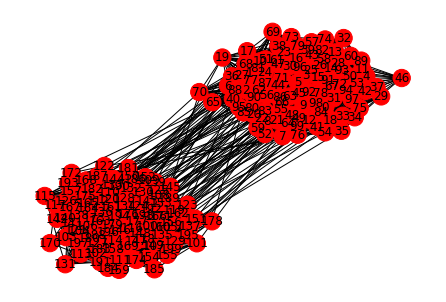

In [7]:
pred_clique_color = ["r" if node in pred_clique_idx else "b" for node in range(len(G))]
nx.draw(G, G_pos, node_color = pred_clique_color, with_labels=True)

For the two clique, this find some nodes of two communities. Therefore, we can use number of common neighbors to determine whether there is a community. All red nodes are nodes in a community. But we need to find a way for partition the communities.

#### Using DFS to find the community of node i:

In [8]:
com_0 = dcn.findCommunities(G, 0, thre = 5)

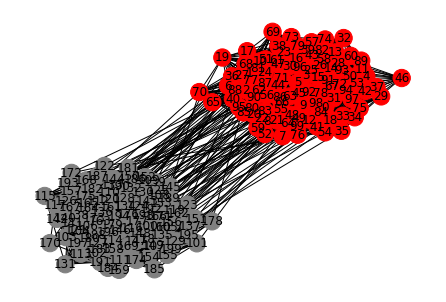

In [9]:
pred_clique_color = ["r" if node in com_0 else "grey" for node in range(len(G))]
nx.draw(G, G_pos, node_color = pred_clique_color, with_labels=True)

This implementation can successfully find the first community with 100 accuracy.

Accuracy

In [10]:
def findAcc(community, n, community_range_lower, community_range_higher):
    correct_preds = 0
    for x in community:
        if x in range(community_range_lower, community_range_higher):
            correct_preds += 1
    return correct_preds / n

In [11]:
findAcc(com_0, 100, 0, 100)

1.0

In [12]:
com_150 = dcn.findCommunities(G, 150, thre = 5)

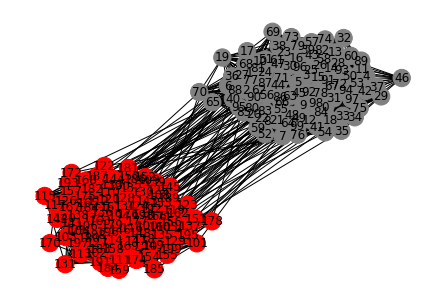

In [13]:
pred_clique_color = ["r" if node in com_150 else "grey" for node in range(len(G))]
nx.draw(G, G_pos, node_color = pred_clique_color, with_labels=True)

Accuracy

In [14]:
findAcc(com_150, 100, 100, 200)

1.0

This implementation can successfully find the second community with 100 accuracy.

#### Different thresholds

In [15]:
accs = []
for th in range(1, 20):
    com = dcn.findCommunities(G, 0, thre = th)
    accs.append(findAcc(com, 100, 0, 100))

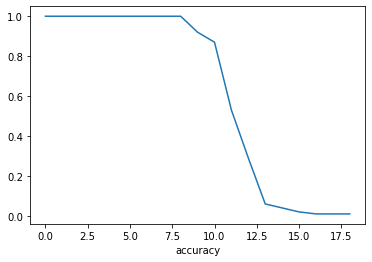

In [16]:
plt.plot(accs)
plt.xlabel("threshold")
plt.xlabel("accuracy")
plt.show()

As we can see, for low thresholds, it can always find the community, but higher threshold might exclude some in-group vertices whose connectedness is obviously less.

## Try Other Random Graphs


In [35]:
N = 1000
n_groups = 10
p_in_group = 0.1
p_out_group = 0.05

In [36]:
G = nx.planted_partition_graph(n_groups, 100, p_in_group, p_out_group, seed=r_seed)

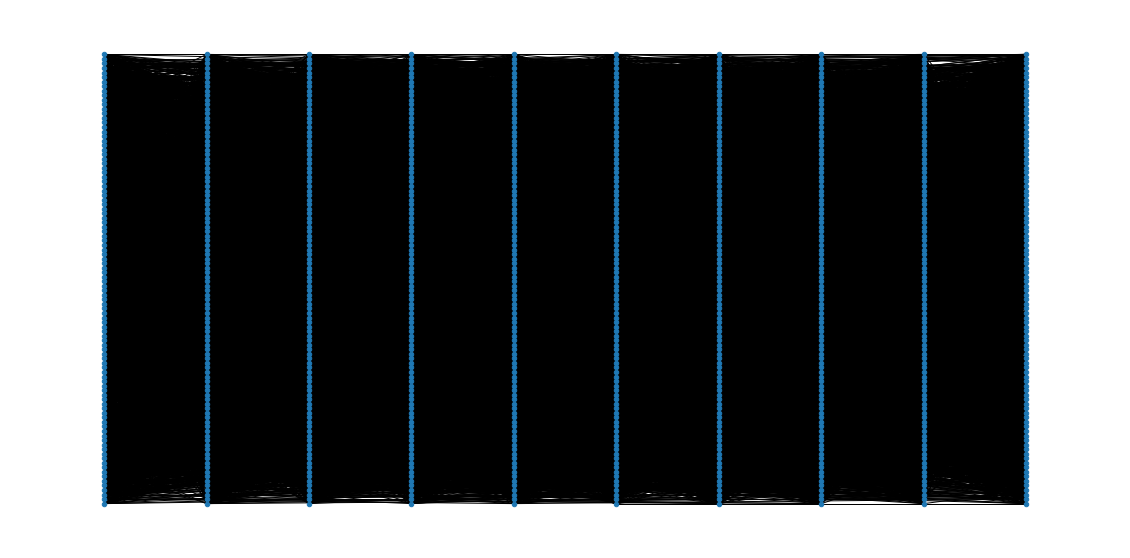

In [37]:
G_pos = nx.multipartite_layout(G, subset_key="block")
fig, ax = plt.subplots(figsize=(20, 10))
nx.draw(G, node_size=20, pos=G_pos)

In [38]:
com_0 = dcn.findCommunities(G, 0, thre = 5)
findAcc(com_0, 100, 0, 100)

0.82

In [39]:
com_100 = dcn.findCommunities(G, 100, thre = 5)
findAcc(com_100, 100, 100, 200)

0.76

In [40]:
com_200 = dcn.findCommunities(G, 100, thre = 5)
findAcc(com_200, 100, 200, 300)

0.83

In [63]:
N = 300
n_groups = 3
p_in_group = 0.1
p_out_group = 0.09
G = nx.planted_partition_graph(n_groups, 100, p_in_group, p_out_group, seed=r_seed)

In [64]:
com_0 = dcn.findCommunities(G, 0, thre = 5)
findAcc(com_0, 100, 0, 100)

0.43

In [65]:
com_100 = dcn.findCommunities(G, 100, thre = 5)
findAcc(com_100, 100, 100, 200)

0.47

In [66]:
com_200 = dcn.findCommunities(G, 100, thre = 5)
findAcc(com_200, 100, 200, 300)

0.28

Try Tuning Threshold with Weight Threshold

In [67]:
def find_avg_cc(G):
    avg = 0
    for i in G.nodes:
        for j in G.nodes:
            if i == j:
                continue

            avg += len(list(nx.common_neighbors(G, i, j)))

    print("number of sum of cc:", avg)
    print("number of nodes:", G.order())
    return avg / G.order()

In [68]:
weight = 1.0
avg_cc = find_avg_cc(G)
avg_cc

number of sum of cc: 221332
number of nodes: 300


737.7733333333333

In [69]:
def findCom0(weight, avg_cc):
    com_0 = dcn.findCommunities(G, 100, thre = weight * avg_cc)
    return findAcc(com_0, 100, 0, 100)

In [70]:
findCom0(1.0, avg_cc)

0.0

In [82]:
findCom0(0.0001, avg_cc)

1.0

In [97]:
accs = []
thrds = []
for w in np.arange(0.0001, 0.01, 0.0005):
    th = w * avg_cc
    thrds.append(th)
    accs.append(findCom0(w, avg_cc))

da = pd.DataFrame({"threshold": thrds, "accuracy": accs})
da.head()

,threshold,accuracy
0,0.073777,1.0
1,0.442664,1.0
2,0.811551,1.0
3,1.180437,1.0
4,1.549324,1.0


<AxesSubplot:xlabel='threshold', ylabel='accuracy'>

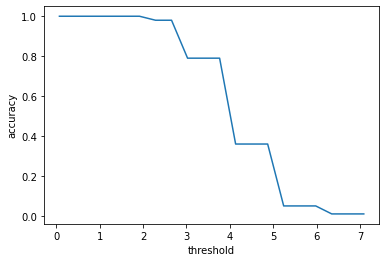

In [104]:
sns.lineplot(data=da, x="threshold", y="accuracy")

### Try real Dataset

Use EU emails dataset, and create a graph based on that.
NOTE: EU emails are directed, but common neighbors method in networkx does not support directed graph. use undirected instead, but some edges like self loops are eliminated.

In [27]:
g_real = nx.read_edgelist("data\email-Eu-core.txt", nodetype=int)
print("number of nodes ", g_real.order())
print("number of edges ", g_real.size())

number of nodes  1005
number of edges  16706


Use community 1 which is the community of node 0 to test

In [28]:
community_1 = list(dcn.findCommunities(g_real, 0, thre = 24))
len(community_1)

354

In [29]:
community_1_actual = []
with open("data\email-Eu-core-department-labels.txt") as r:
    lines = r.readlines()
    for line in lines:
        node = int(line.split(" ")[0])
        commu = int(line.split(" ")[1])
        if commu == 1:
            community_1_actual.append(node)

len(community_1_actual)

65

Unfortunately, with low thresholds, it is observed that the predicted community is always obviously greater than the actual community. However, once we increase the threshold, it always find large community or cannot identify the community. Specifically, it always find large community or a community of 1 node.

In [30]:
def accReal(pred_com, actual_com):
    correct = 0
    for x in pred_com:
        if x in actual_com:
            correct += 1
    return correct / len(actual_com)

In [31]:
accReal(community_1, community_1_actual)

0.26153846153846155

##### Different thresholds

In [32]:
accs = []
for th in range(1, 30):
    com = dcn.findCommunities(g_real, 0, thre = th)
    accs.append(accReal(com, community_1_actual))

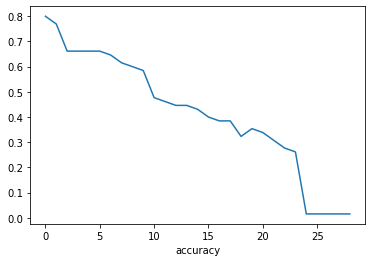

In [33]:
plt.plot(accs)
plt.xlabel("threshold")
plt.xlabel("accuracy")
plt.show()

As we only find the community for node 0, and the predicted community is obviously larger than expected. The thresholds seems not work well.